In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from problem import Poisson_2d
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [3]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]

def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)

    grad_u = grad(u_pde, x_pde)
    u_x = grad_u[:, [0]]
    u_y = grad_u[:, [1]]

    u_xx = grad(u_x, x_pde)[:, [0]]
    u_yy = grad(u_y, x_pde)[:, [1]]

    pde_value = u_xx + u_yy
    return pde_value

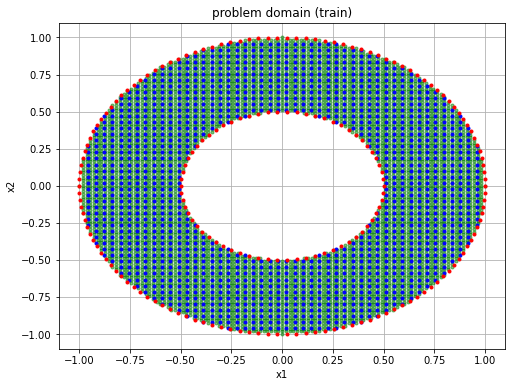

In [4]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_test = data['x_test']

target_pde = data['target_pde']
target_bd = data['target_bd'].item()['u']
target_test = data['target_test'].item()['u']


plot_domain_2d(x_pde=x_pde, x_bd=x_bd, x_test=x_test)


In [5]:
x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_test = torch.from_numpy(x_test).float()

target_pde = torch.from_numpy(target_pde).float()
target_bd = torch.from_numpy(target_bd).float()
target_test = torch.from_numpy(target_test).float()
print(x_pde.shape, target_pde.shape)
print(x_bd.shape, target_bd.shape)
print(x_test.shape, target_test.shape)

torch.Size([1408, 2]) torch.Size([1408, 1])
torch.Size([200, 2]) torch.Size([200, 1])
torch.Size([7100, 2]) torch.Size([7100, 1])


In [6]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = criterion(op_pde, target_pde)

    u_bd = model(x_bd)
    loss_bd = criterion(u_bd, target_bd)

    loss = loss_pde + loss_bd

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()

        op_pde = pde(x_pde, model)
        loss_pde = criterion(op_pde, target_pde)

        u_bd = model(x_bd)
        loss_bd = criterion(u_bd, target_bd)

        loss = loss_pde + loss_bd
        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [7]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()
    target_pde = target_pde.cuda()
    target_bd = target_bd.cuda()
    target_test = target_test.cuda()


In [8]:

def train(width):
    model  = FCNet(input_dim=2, output_dim=1, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())

    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())
    return record_epoch, train_loss, test_mse

In [9]:
width_vec = [100,250,500,750,1000]
result_all = []
for width in width_vec:
    print(width,'.....................')

    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

100 .....................
0 1520.80126953125
100 1496.7242431640625
200 1402.614013671875
300 1314.22802734375
400 1282.9720458984375
500 1220.126220703125
600 1084.2752685546875
700 826.5180053710938
800 521.7152099609375
900 341.3960876464844
1000 267.0606689453125
1100 211.9541473388672
1200 156.78024291992188
1300 101.42135620117188
1400 55.593101501464844
1500 29.14751434326172
1600 17.052371978759766
1700 11.741365432739258
1800 9.036735534667969
1900 7.510777950286865
2000 6.557010650634766
2100 6.047283172607422
2200 5.605451583862305
2300 5.20781135559082
2400 4.841921329498291
2500 4.500384330749512
2600 4.1821160316467285
2700 3.8873305320739746
2800 3.6143083572387695
2900 3.359891414642334
3000 3.1212425231933594
3100 2.8960628509521484
3200 2.682326316833496
3300 2.4779577255249023
3400 2.2814383506774902
3500 2.093832492828369
3600 1.9177427291870117
3700 1.7533071041107178
3800 1.5965148210525513
3900 1.4400043487548828
4000 1.2800440788269043
4100 1.1692419052124023
42

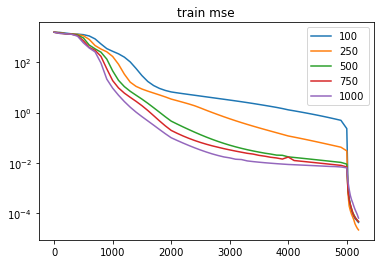

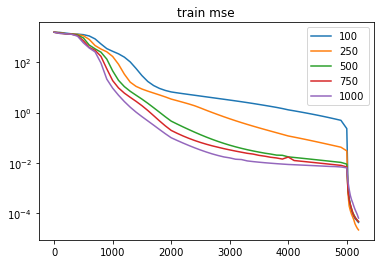

In [14]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

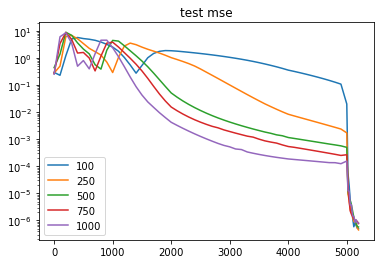

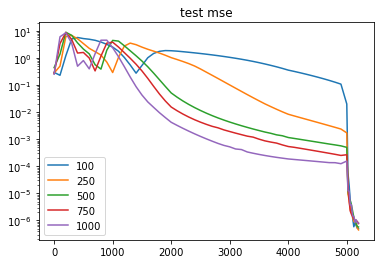

In [15]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [16]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

In [17]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')